# Exploring NYC Restaurant Inspection Data

# Hyera and PJ's Lab Notebook

# Dataset description
For our project, we are interested in exploring inspection data for restaurants in New York City.

# SECTION 1: Dataframes

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#### In order to process the data in a way that is well suited for analyses, the following steps occurred to create three separate DataFrames:

1. Parsing and Removal - 'INSPECTION DATE' is parsed during read-in from the original data (saved as 'NYCdata.csv') found here: https://nycopendata.socrata.com/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/xx67-kt59. Then, the index is set to these dates, but datetime values of "1900-01-01" were excluded.

2. Deduplication - duplicate inspection dates were removed so that multiple violations or comments for the same inspection day do not result in erroneous counts for corresponding inspection types and scores/grades.

3. Latest Inclusion - only the data for the maximum index date (i.e. inspection date) for each restaurant was kept for this dataframe.

### Dataframe \# 1: base dataframe
1. Inspection dates parsed and set as index
2. Data with '1900-01-01' inspection dates removed

In [3]:
df = pd.read_csv('NYCdata.csv', parse_dates = ['INSPECTION DATE'])

df_dated = df.copy()
df_dated.set_index('INSPECTION DATE', inplace=True)
df_dated = df_dated[df_dated.index != '1900-01-01']

print("Length before removing 1900-01-01:" ,len(df), "\nLength after removing 1900-01-01:", len(df_dated))

Length before removing 1900-01-01: 466419 
Length after removing 1900-01-01: 465394


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Dataframe \#2: inspection date duplicates removed for each restaurant, and Dataframe \#3: only most recent inspection date kept for each restaurant

In [4]:
# De-duplication of dates (primarily to prevent issues due to duplicate grades/scores when answering certain questions)
# Note: inspection details for each score are lost thus, for details, use df_dated
# Source: http://pandas.pydata.org/pandas-docs/stable/merging.html

frames2 = []  # Separate frames for DF2 will be added here
frames3 = []  # Separate frames for DF3 will be added here
for identifier in df_dated['CAMIS'].unique():
    
    # To create DF2
    curr_df = df_dated[df_dated['CAMIS'] == identifier]  # New dataframe for each identifier
    curr_df = curr_df[~curr_df.index.duplicated(keep='first')]  # Magic method for removing duplicate index dates
    curr_df = curr_df[::-1]  # Date sorted. Note: in initial dataset, dates are sorted in descending order
    frames2.append(curr_df)  # Save dataframe to list
    
    # To create DF3
    curr_df2 = curr_df[curr_df.index == curr_df.index.max()] # Keep ID with only the most recent date
    frames3.append(curr_df2)  # Save dataframe to list

# Combine dataframes to create DF2, DF3
df_dedupe = pd.concat(frames2)
df_dedupeID = pd.concat(frames3)

print("Length before removing inspection dates duplicates (DF1):", len(df_dated))
print("Length after removing inspection dates duplicates (DF2):", len(df_dedupe))
print("Length when only keeping the most recent inspection results per restaurant (DF3):", len(df_dedupeID))

Length before removing inspection dates duplicates (DF1): 465394
Length after removing inspection dates duplicates (DF2): 155902
Length when only keeping the most recent inspection results per restaurant (DF3): 24908


In [5]:
# Save copies just in case
df_dated.to_csv('NYCdataDF1.csv')
df_dedupe.to_csv("NYCdataDF2.csv")
df_dedupeID.to_csv("NYCdataDF3.csv")

# SECTION 2: Data analysis section

### Question \#1a: What are the most frequent types of inspections (e.g. cycle, smoke free air, etc..)?

Information available from the dataset: Use dataset df_dedupe and the column "INSPECTION TYPE" and group by inspection type.

Problem: We noted that there are several types within each cell so need to split them into different columns.

Solution: Based on the Python course office hours, we will use the approach to split the types and create columns



In [6]:
# Create a list of all inspection types
from itertools import chain
types_raw = set(chain.from_iterable(df_dated['INSPECTION TYPE']\
                                    .map(str)\
                                    .map(lambda x: x.split("/")).tolist()))
types = [item.strip(" ") for item in types_raw if item != '']
print(types)

['Initial Inspection', 'Compliance Inspection', 'Reopening Inspection', 'Smoke-Free Air Act', 'Pre-permit (Operational)', 'Trans Fat', 'Limited Inspection', 'Second Compliance Inspection', 'Calorie Posting', 'Pre-permit (Non-operational)', 'Re-inspection', 'Cycle Inspection', 'Administrative Miscellaneous', 'Inter-Agency Task Force']


In [7]:
# Create columns for each inspection type and fill in with True/False
for insp_type in types:
    column_name = "Inspection_type_is_" + insp_type
    df_dedupe[column_name] = df_dedupe['INSPECTION TYPE'].map(lambda x: insp_type in str(x))
    
df_dedupe.head()  # columns per inspection types are well created!

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,ACTION,VIOLATION CODE,...,Inspection_type_is_Pre-permit (Operational),Inspection_type_is_Trans Fat,Inspection_type_is_Limited Inspection,Inspection_type_is_Second Compliance Inspection,Inspection_type_is_Calorie Posting,Inspection_type_is_Pre-permit (Non-operational),Inspection_type_is_Re-inspection,Inspection_type_is_Cycle Inspection,Inspection_type_is_Administrative Miscellaneous,Inspection_type_is_Inter-Agency Task Force
INSPECTION DATE,,,,,,,,,,,,,,,,,,,,,
2013-06-01,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462,7188924968,Bakery,Violations were cited in the following area(s).,16B,...,False,True,False,False,False,False,False,False,False,False
2013-08-14,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462,7188924968,Bakery,Violations were cited in the following area(s).,04C,...,False,False,False,False,False,False,False,True,False,False
2013-09-11,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462,7188924968,Bakery,Violations were cited in the following area(s).,04L,...,False,False,False,False,False,False,True,True,False,False
2013-10-10,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462,7188924968,Bakery,No violations were recorded at the time of thi...,NaN,...,False,True,False,True,False,False,False,False,False,False
2014-03-03,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462,7188924968,Bakery,Violations were cited in the following area(s).,10F,...,False,False,False,False,False,False,False,True,False,False


In [8]:
# List of columns starting with inspection types
insp_types_cols = [col for col in df_dedupe.columns if col.startswith("Inspection_type_is")]
print(insp_types_cols)

['Inspection_type_is_Initial Inspection', 'Inspection_type_is_Compliance Inspection', 'Inspection_type_is_Reopening Inspection', 'Inspection_type_is_Smoke-Free Air Act', 'Inspection_type_is_Pre-permit (Operational)', 'Inspection_type_is_Trans Fat', 'Inspection_type_is_Limited Inspection', 'Inspection_type_is_Second Compliance Inspection', 'Inspection_type_is_Calorie Posting', 'Inspection_type_is_Pre-permit (Non-operational)', 'Inspection_type_is_Re-inspection', 'Inspection_type_is_Cycle Inspection', 'Inspection_type_is_Administrative Miscellaneous', 'Inspection_type_is_Inter-Agency Task Force']


In [9]:
# Test case: check first row
df_dedupe.iloc[0]

CAMIS                                                                                       30075445
DBA                                                                            MORRIS PARK BAKE SHOP
BORO                                                                                           BRONX
BUILDING                                                                                        1007
STREET                                                                               MORRIS PARK AVE
ZIPCODE                                                                                        10462
PHONE                                                                                     7188924968
CUISINE DESCRIPTION                                                                           Bakery
ACTION                                               Violations were cited in the following area(s).
VIOLATION CODE                                                                             

In [10]:
df_dedupe[insp_types_cols].sum().sort_values(ascending=False)

Inspection_type_is_Cycle Inspection                133703
Inspection_type_is_Initial Inspection               97057
Inspection_type_is_Re-inspection                    53582
Inspection_type_is_Pre-permit (Operational)         13706
Inspection_type_is_Compliance Inspection             2691
Inspection_type_is_Pre-permit (Non-operational)      2601
Inspection_type_is_Reopening Inspection              2568
Inspection_type_is_Administrative Miscellaneous      2454
Inspection_type_is_Trans Fat                         1686
Inspection_type_is_Smoke-Free Air Act                 928
Inspection_type_is_Inter-Agency Task Force            636
Inspection_type_is_Second Compliance Inspection       409
Inspection_type_is_Calorie Posting                    188
Inspection_type_is_Limited Inspection                   4
dtype: int64

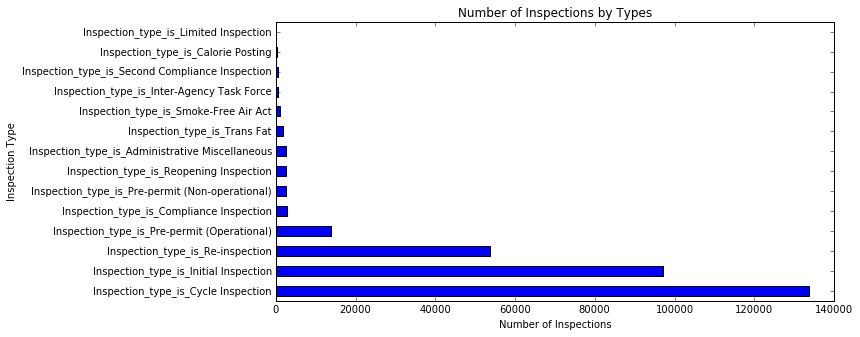

In [11]:
df_dedupe[insp_types_cols].sum().sort_values(ascending=False).plot(kind='barh', figsize=(10,5))
plt.title("Number of Inspections by Types")
plt.xlabel("Number of Inspections")
plt.ylabel("Inspection Type")
plt.savefig('Inspections_by_Types.png')

Based on the graph above, the most frequent types of inspections are a cycle inspection, then initial inspection. Note that the initial and cycle inspection are typically combined together.

### Question \#1b: For initial inspections, what is the most common grade?

Based on the columns created in 1b, filter the initial inspection data and count each grade with value_counts()

In [12]:
initial_total = df_dedupe[df_dedupe['Inspection_type_is_Initial Inspection'] == True]
print(len(initial_total))

initial_grade = initial_total.GRADE.fillna("Missing grade").value_counts().sort_values(ascending=False)
initial_grade

97057


Missing grade     58275
A                 38274
Not Yet Graded      507
C                     1
Name: GRADE, dtype: int64

Conclusion:

Grade information is missing for the majority of initial inspections. An A is the second most frequent grade resulting from initial inspections.

In fact, this result aligns with how NYC Department of Health rules of when a score is converted to a grade. In summary, two types of inspections result in a letter grade: initial inspections for which the restaurant earns an A and re-inspections that result in an A, B or C. A restaurant has two chances to earn an A in every inspection cycle and if it doesn't earn an A on the first inspection, it's scored but ungraded. It will be graded at re-inspection. This explains how most initial inspections have no grades (in our data, either missing or "Not yet graded") but a score.

In [13]:
# Test cases to verify initial inspection with no grade then re-inspection with a grade
initial_reinsp = df_dedupe[(df_dedupe['Inspection_type_is_Initial Inspection'] == True) | \
                          (df_dedupe['Inspection_type_is_Re-inspection'] == True)]

initial_reinsp[['CAMIS','INSPECTION TYPE', 'SCORE', 'GRADE']].head(20)

,CAMIS,INSPECTION TYPE,SCORE,GRADE
INSPECTION DATE,,,,
2013-08-14,30075445,Cycle Inspection / Initial Inspection,32.0,NaN
2013-09-11,30075445,Cycle Inspection / Re-inspection,6.0,A
2014-03-03,30075445,Cycle Inspection / Initial Inspection,2.0,A
2015-02-09,30075445,Cycle Inspection / Initial Inspection,6.0,A
2016-02-18,30075445,Cycle Inspection / Initial Inspection,10.0,A
2012-05-08,30112340,Cycle Inspection / Initial Inspection,12.0,A
2013-04-30,30112340,Cycle Inspection / Initial Inspection,12.0,A
2014-06-05,30112340,Cycle Inspection / Initial Inspection,13.0,NaN
2014-07-01,30112340,Cycle Inspection / Re-inspection,23.0,B


Since at initial inspection, it is either an A or no grade, we decided to also check what are the grades at re-inspections (see below). We noted a quite significant number of B and C.

In [14]:
reinsp_total = df_dedupe[df_dedupe['Inspection_type_is_Re-inspection'] == True]
print(len(reinsp_total))

reinsp_grade = reinsp_total.GRADE.fillna("Missing grade").value_counts().sort_values(ascending=False)
reinsp_grade

53582


A                 38900
B                 10491
Missing grade      1866
C                  1777
Z                   517
Not Yet Graded       31
Name: GRADE, dtype: int64

### Question \#2: When are the inspections most frequent?

In [15]:
q2 = df_dedupe.copy() # The second DataFrame (df_dedupe) is the most appropriate to address this question
q2.dtypes

CAMIS                                                int64
DBA                                                 object
BORO                                                object
BUILDING                                            object
STREET                                              object
ZIPCODE                                              int64
PHONE                                               object
CUISINE DESCRIPTION                                 object
ACTION                                              object
VIOLATION CODE                                      object
VIOLATION DESCRIPTION                               object
CRITICAL FLAG                                       object
SCORE                                              float64
GRADE                                               object
GRADE DATE                                          object
RECORD DATE                                         object
INSPECTION TYPE                                     obje

There are many kinds of inspections, as we have seen in Q1.
The first challenge was to think which dataframe will be the most suited for this question.
After a number of trials, unlike Q1, we decided to keep the combination of types instead of splitting them since we are only interested in the number of inspections occurances

In [16]:
q2['INSPECTION TYPE'].value_counts() 

Cycle Inspection / Initial Inspection                          83076
Cycle Inspection / Re-inspection                               47673
Pre-permit (Operational) / Initial Inspection                   8169
Pre-permit (Operational) / Re-inspection                        4738
Pre-permit (Non-operational) / Initial Inspection               2392
Cycle Inspection / Reopening Inspection                         2165
Administrative Miscellaneous / Initial Inspection               2019
Trans Fat / Compliance Inspection                                825
Cycle Inspection / Compliance Inspection                         763
Smoke-Free Air Act / Initial Inspection                          636
Inter-Agency Task Force / Initial Inspection                     634
Trans Fat / Re-inspection                                        543
Pre-permit (Operational) / Reopening Inspection                  392
Pre-permit (Operational) / Compliance Inspection                 385
Trans Fat / Second Compliance Insp

#### Inspections frequency: day of the week

In [17]:
q2['DAY OF WEEK'] = q2.index.map(lambda x: x.strftime("%A"))
q2['DAY OF WEEK'].value_counts()

Wednesday    35240
Thursday     34175
Tuesday      32513
Monday       25068
Friday       21257
Saturday      7263
Sunday         386
Name: DAY OF WEEK, dtype: int64

Observation: very few weekend inspections as we have expected. Also inspections are more frequent in the mid-week (Tuesday to Thursdays).

In [18]:
q2.groupby('DAY OF WEEK')['INSPECTION TYPE'].describe() # Initial inspections for cycle inspections are most common

DAY OF WEEK        
Friday       count                                            21257
             unique                                              32
             top              Cycle Inspection / Initial Inspection
             freq                                             11301
Monday       count                                            25068
             unique                                              26
             top              Cycle Inspection / Initial Inspection
             freq                                             13297
Saturday     count                                             7263
             unique                                              30
             top              Cycle Inspection / Initial Inspection
             freq                                              4099
Sunday       count                                              386
             unique                                               7
             top       Inter

Since we're dealing with many different kinds of inspections, it's time to group the inspections into their main categories. In doing so, we're ignoring the secondary categories (i.e. whether it's initial, re-inspection, compliance, or limited is not of interest for this question - see question 1 instead).

NOTE: We are not sure what Administrative or Inter-Agency Task Force inspections are all about. We also noted that Calorie Posting Inspections account for only a few inspections. So, these three are lumped into "Other" to reduce the number of categories. We also tested that these 3 combined under "Other" is not significant percentage of the total inspection count.

In [19]:
def inspection_type_combine(value):
    'Return the main type of inspection'
    if value.startswith("Smoke"):
        return "Smoke-free Air Act Inspection"
    elif value.startswith("Cycle"):
        return "Cycle Inspection"
    elif value.startswith("Pre-permit"):
        return "Pre-permit Inspection"
    elif value.startswith("Trans"):
        return "Trans Fat Inspection"
    elif "nspection" in value:
        return "Other Inspection" # Administrative, Inter-Agency Task Force, and Calorie Posting go here
    else:
        return np.nan # should not happen

q2['INSPECTION TYPE COMBINED'] = q2['INSPECTION TYPE'].map(lambda x: inspection_type_combine(str(x)))
q2['INSPECTION TYPE COMBINED'].value_counts()  # note the same total count as df_dedupe which means no missing values

Cycle Inspection                 133703
Pre-permit Inspection             16307
Other Inspection                   3278
Trans Fat Inspection               1686
Smoke-free Air Act Inspection       928
Name: INSPECTION TYPE COMBINED, dtype: int64

In [20]:
q2.groupby('DAY OF WEEK')['INSPECTION TYPE COMBINED'].describe()
# So, when grouped into what kind of inspection we can see that cycle inspections are actually the most common on all days.

DAY OF WEEK        
Friday       count                21257
             unique                   5
             top       Cycle Inspection
             freq                 18119
Monday       count                25068
             unique                   5
             top       Cycle Inspection
             freq                 21905
Saturday     count                 7263
             unique                   5
             top       Cycle Inspection
             freq                  5715
Sunday       count                  386
             unique                   3
             top       Cycle Inspection
             freq                   191
Thursday     count                34175
             unique                   5
             top       Cycle Inspection
             freq                 29322
Tuesday      count                32513
             unique                   5
             top       Cycle Inspection
             freq                 28124
Wednesday    count  

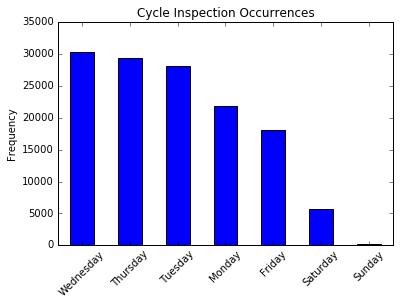

In [21]:
# Starting with All Cycle Inspections, we can see that few of them occur on weekends
q2[q2['INSPECTION TYPE COMBINED'] == 'Cycle Inspection']['DAY OF WEEK'].value_counts().plot(kind='bar', rot=45)
plt.title("Cycle Inspection Occurrences")
plt.ylabel("Frequency")

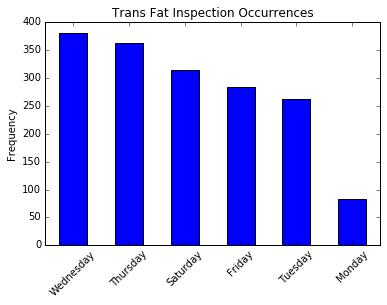

In [22]:
# Trans fat inspections are uncommon on Mondays and don't occur on Sundays
q2[q2['INSPECTION TYPE COMBINED'] == 'Trans Fat Inspection']['DAY OF WEEK'].value_counts().plot(kind='bar', rot=45)
plt.title("Trans Fat Inspection Occurrences")
plt.ylabel("Frequency")

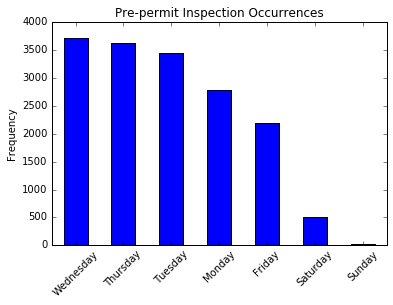

In [23]:
# Pre-permit inspections rarely take place on weekends
q2[q2['INSPECTION TYPE COMBINED'] == 'Pre-permit Inspection']['DAY OF WEEK'].value_counts().plot(kind='bar', rot=45)
plt.title("Pre-permit Inspection Occurrences")
plt.ylabel("Frequency")

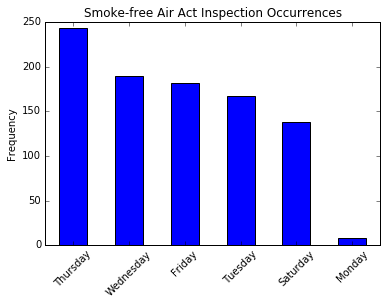

In [24]:
# Smoke-free Air Act inspections are a rare sight on Mondays and do not occur on Saturdays.
q2[q2['INSPECTION TYPE COMBINED'] == 'Smoke-free Air Act Inspection']['DAY OF WEEK'].value_counts().plot(kind='bar', rot=45)
plt.title("Smoke-free Air Act Inspection Occurrences")
plt.ylabel("Frequency")

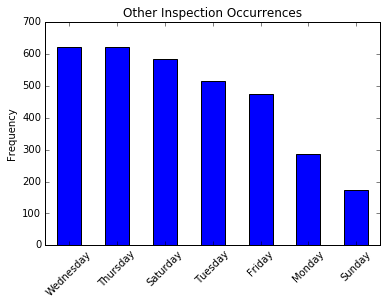

In [25]:
# Other Inspections
q2[q2['INSPECTION TYPE COMBINED'] == 'Other Inspection']['DAY OF WEEK'].value_counts().plot(kind='bar', rot=45)
plt.title("Other Inspection Occurrences")
plt.ylabel("Frequency")

Taking all of the above into consideration... If you're a restaurant owner, you can probably worry less during the weekends about a cycle or pre-permit inspection, especially on Sundays. There is also no reason to expect a trans fat or smoke-free air act inspection on Sunday, but Saturday is free game for both as well as other kinds of inspections!

From a consumer standpoint, it's hard to say how this might be relevant. There is a delay between the inspection day and the time final results become available to the public. However, if restaurant managers are aware of these trends and take action in anticipation of certain inspections, I'd recommend eating out on Thursdays, Wednesdays, and possibly Tuesdays, since these are the most common inspection days.

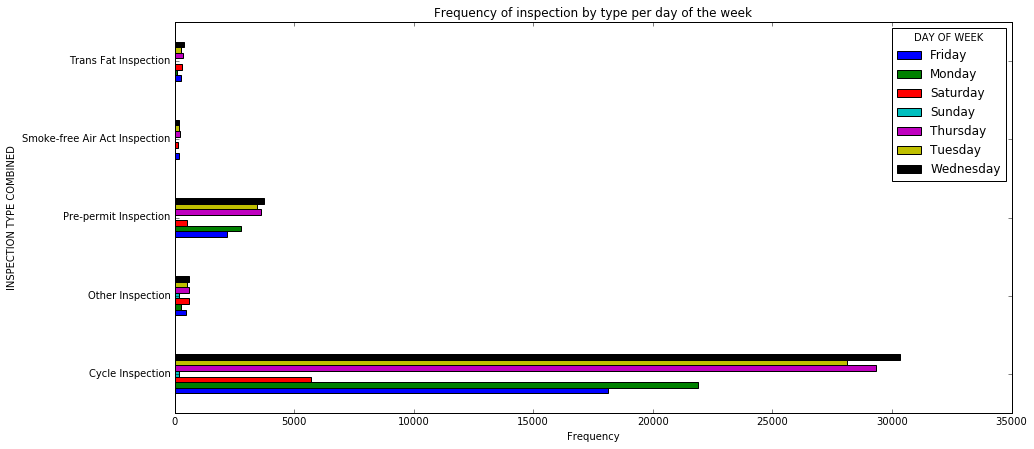

In [26]:
# Combined plot
q2_grouped = q2.groupby(['INSPECTION TYPE COMBINED', 'DAY OF WEEK'])
grouped = q2_grouped['DAY OF WEEK'].count().sort_index()
grouped.unstack().plot(kind='barh', figsize=(15,7))
plt.title('Frequency of inspection by type per day of the week')
plt.xlabel('Frequency')

#### Inspections frequency: by season

Challenge: how to associate a season for each date? We will take the approach of creating a column that contains the month and day in a datetime format and map a function that will return a season.

We based the beginning and end date of each season googling the official winter/spring/summer/fall dates.

In [27]:
def compute_season(value):
    # Sources for determining season:
    # 1) Googling "official spring/summer/fall/winter dates"
    # 2) https://simple.wikipedia.org/wiki/Solstice
    if (value > '03-19' and value < '06-21'):
        return 'Spring'
    elif (value > '06-20' and value < '09-23'):
        return 'Summer'
    elif (value > '09-22' and value < '12-22'):
        return 'Fall'
    elif ((value > '12-21' and value <= '12-31') or (value >= '01-01' and value < '3-20')):
        return 'Winter'
    else:
        return 'Error'
    
q2['MONTH-DAY'] = q2.index.map(lambda x: x.strftime("%m-%d"))
q2['SEASON'] = q2['MONTH-DAY'].map(lambda x: compute_season(x))
q2['SEASON'].value_counts()

Spring    44099
Winter    40623
Fall      36231
Summer    34949
Name: SEASON, dtype: int64

In [28]:
q2.groupby('SEASON')['INSPECTION TYPE COMBINED'].describe()  # Same story with Cycle Inspections on day of week

SEASON        
Fall    count                36231
        unique                   5
        top       Cycle Inspection
        freq                 30532
Spring  count                44099
        unique                   5
        top       Cycle Inspection
        freq                 37926
Summer  count                34949
        unique                   5
        top       Cycle Inspection
        freq                 29843
Winter  count                40623
        unique                   5
        top       Cycle Inspection
        freq                 35402
dtype: object

#### Cycle Inspections findings: they seem regular year-round. See graph below.

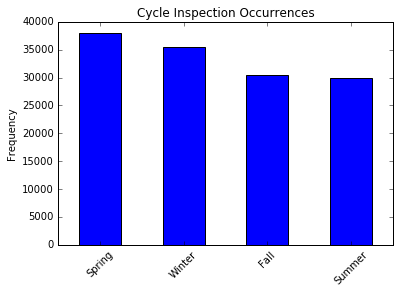

In [29]:
q2[q2['INSPECTION TYPE COMBINED'] == 'Cycle Inspection']['SEASON'].value_counts().plot(kind='bar', rot=45)
plt.title("Cycle Inspection Occurrences")
plt.ylabel("Frequency")

#### Trans fat inspections findings: they occur much less during the winter.
Afterall, who cares about unhealthy fats when you're bundled up and no one can see it?

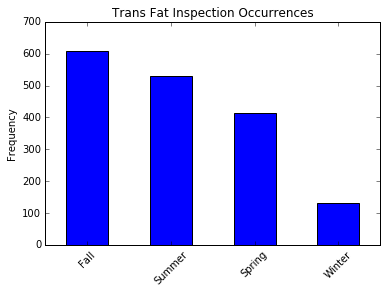

In [30]:
q2[q2['INSPECTION TYPE COMBINED'] == 'Trans Fat Inspection']['SEASON'].value_counts().plot(kind='bar', rot=45)
plt.title("Trans Fat Inspection Occurrences")
plt.ylabel("Frequency")

#### Pre-permit inspections findings: they are fairly regular

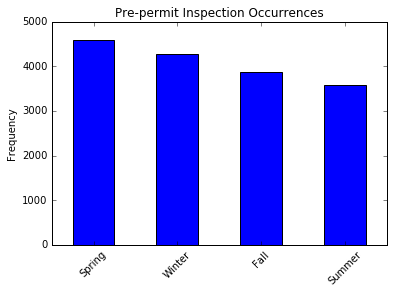

In [31]:
q2[q2['INSPECTION TYPE COMBINED'] == 'Pre-permit Inspection']['SEASON'].value_counts().plot(kind='bar', rot=45)
plt.title("Pre-permit Inspection Occurrences")
plt.ylabel("Frequency")

#### Smoke-free Air Act inspections findings: they are fairly regular, a little less frequent during winter.

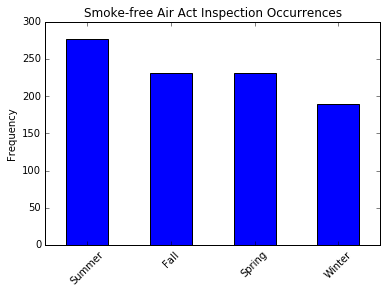

In [32]:
q2[q2['INSPECTION TYPE COMBINED'] == 'Smoke-free Air Act Inspection']['SEASON'].value_counts().plot(kind='bar', rot=45)
plt.title("Smoke-free Air Act Inspection Occurrences")
plt.ylabel("Frequency")

#### Other Inspections findings: they are slightly fewer in Summer & Winter

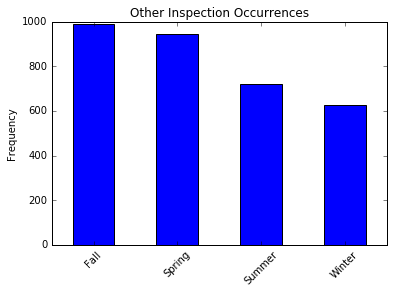

In [33]:
q2[q2['INSPECTION TYPE COMBINED'] == 'Other Inspection']['SEASON'].value_counts().plot(kind='bar', rot=45)
plt.title("Other Inspection Occurrences")
plt.ylabel("Frequency")

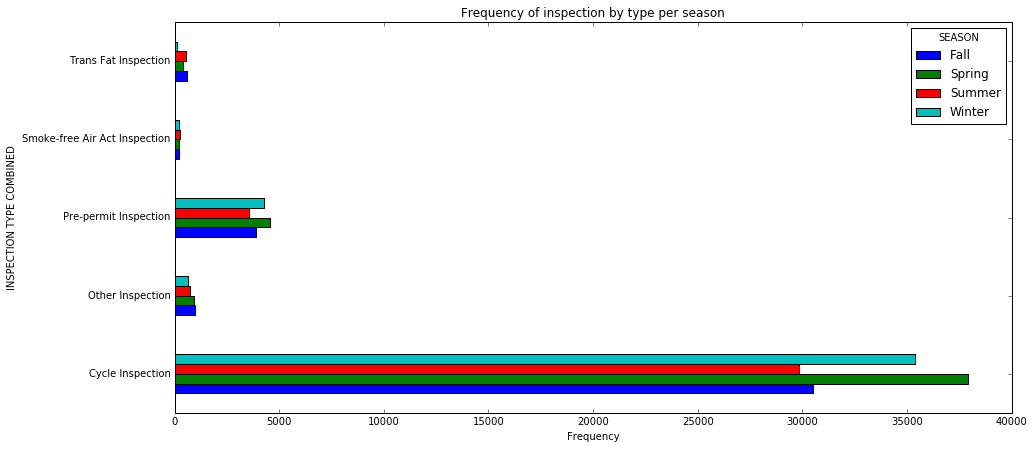

In [34]:
# Combined the above plots into one
q2_grouped = q2.groupby(['INSPECTION TYPE COMBINED', 'SEASON'])
grouped = q2_grouped['SEASON'].count().sort_index()
grouped.unstack().plot(kind='barh', figsize=(15,7))
plt.title('Frequency of inspection by type per season')
plt.xlabel('Frequency')

### Question \#3: Which types of food have the lowest grades or scores?

In [35]:
q3 = df_dedupeID.copy()  # df_dedupeID is used since we care about the latest inspection scores
len(q3["CUISINE DESCRIPTION"].unique())  # There are 84 unique food types

84

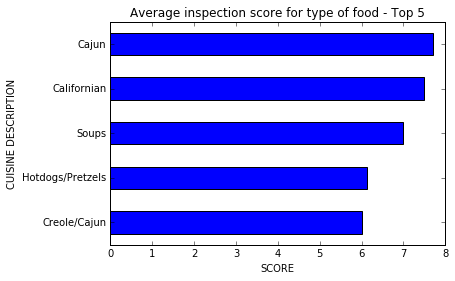

In [36]:
q3.groupby("CUISINE DESCRIPTION")["SCORE"].mean().sort_values()[0:5].plot(kind='barh')
plt.title("Average inspection score for type of food - Top 5")
plt.xlabel("SCORE")

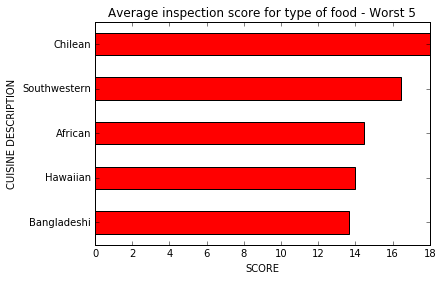

In [37]:
q3.groupby("CUISINE DESCRIPTION")["SCORE"].mean().sort_values(ascending=False)[0:5][::-1].plot(kind='barh', color='red')
plt.title("Average inspection score for type of food - Worst 5")
plt.xlabel("SCORE")

In [38]:
q3["CUISINE DESCRIPTION"].value_counts()

American                                                            6104
Chinese                                                             2398
CafÃ©/Coffee/Tea                                                    1364
Pizza                                                               1167
Italian                                                             1050
Latin (Cuban, Dominican, Puerto Rican, South & Central American)     883
Mexican                                                              814
Japanese                                                             789
Bakery                                                               719
Caribbean                                                            649
Spanish                                                              611
Donuts                                                               496
Pizza/Italian                                                        463
Sandwiches                                         

#### Challenge - the results can be sometimes distorted if there is not enough data.
All of the Top 5 had fewer than 25 total inspections to use for averaging!
- Hotdogs/Pretzels - 22
- Cajun - 7
- Soups - 3
- Californian - 2
- Creole/Cajun - 2

Next step is to only use common food types. We need to decide on a minimum number of inspections so that our findings are more reliable (at least 100 instances?)

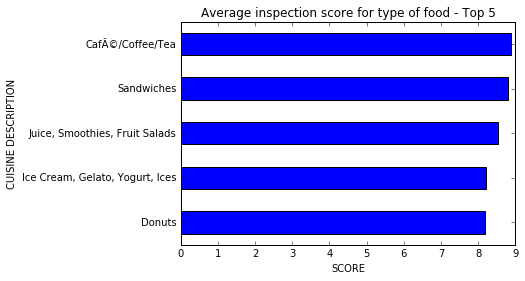

In [39]:
# The next step - top 5 (plot shows best on bottom) for food types with at least 50 occurrences
count_by_cuisine = q3.groupby("CUISINE DESCRIPTION").SCORE.count().values  #an array
avg_score_by_cuisine = q3.groupby("CUISINE DESCRIPTION").SCORE.mean()
df50 = pd.DataFrame({'COUNT': count_by_cuisine, 'SCORE_MEAN': avg_score_by_cuisine})
df50[df50.COUNT >= 50].SCORE_MEAN.sort_values()[0:5].plot(kind='barh')
plt.title("Average inspection score for type of food - Top 5")
plt.xlabel("SCORE")

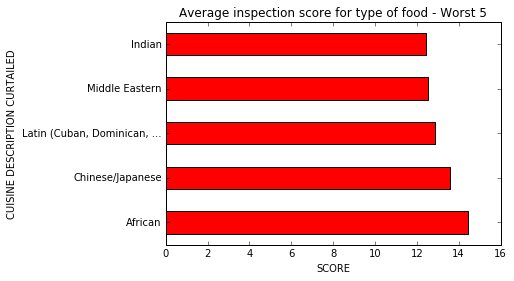

In [40]:
# Challenge: Some descriptions are too long to have on a plot. We need a function to curtail!
def curtail25(value):
    if len(value) > 25:
        value = value[:25] + "..."
    return value

q3_copy = q3.copy()
q3_copy['CUISINE DESCRIPTION CURTAILED'] = q3_copy['CUISINE DESCRIPTION'].map(lambda x: curtail25(str(x)))

# The next step - worst 5 (plot shows worst on bottom) for food types with at least 50 occurrences
count_by_cuisine = q3_copy.groupby('CUISINE DESCRIPTION CURTAILED').SCORE.count().values #an array
avg_score_by_cuisine = q3_copy.groupby('CUISINE DESCRIPTION CURTAILED').SCORE.mean()
df50 = pd.DataFrame({'COUNT': count_by_cuisine, 'SCORE_MEAN': avg_score_by_cuisine})
df50[df50.COUNT >= 50].SCORE_MEAN.sort_values(ascending=False)[0:5].plot(kind='barh', color='red')
plt.title("Average inspection score for type of food - Worst 5")
plt.xlabel("SCORE")

### Question \#4: What are the most common reasons for bad grades?

In [41]:
q4 = df_dated.copy() # df_dated is necessary so that duplicate entries for the same date can be accessed.
# These duplicates will have the same date and score/grade, but different violation codes/descriptions
q4.dtypes

CAMIS                      int64
DBA                       object
BORO                      object
BUILDING                  object
STREET                    object
ZIPCODE                    int64
PHONE                     object
CUISINE DESCRIPTION       object
ACTION                    object
VIOLATION CODE            object
VIOLATION DESCRIPTION     object
CRITICAL FLAG             object
SCORE                    float64
GRADE                     object
GRADE DATE                object
RECORD DATE               object
INSPECTION TYPE           object
dtype: object

In [42]:
q4['VIOLATION DESCRIPTION'].describe() #97 unique, but one is 'nan'; so, only 96

count                                                457334
unique                                                   97
top       Non-food contact surface improperly constructe...
freq                                                  63041
Name: VIOLATION DESCRIPTION, dtype: object

In [43]:
# Challenge: Some descriptions are too long to have on a plot. We need a function to curtail!
def curtail85(value):
    if len(value) > 85:
        value = value[:85] + "..."
    return value

q4['VIOLATION DESCRIPTION CURTAILED'] = q4['VIOLATION DESCRIPTION'].map(lambda x: curtail85(str(x)))
q4.groupby('GRADE')['VIOLATION DESCRIPTION CURTAILED'].describe()

GRADE                 
A               count                                                162181
                unique                                                   65
                top       Non-food contact surface improperly constructe...
                freq                                                  37498
B               count                                                 38292
                unique                                                   60
                top       Facility not vermin proof. Harborage or condit...
                freq                                                   5024
C               count                                                 10576
                unique                                                   58
                top       Facility not vermin proof. Harborage or condit...
                freq                                                   1281
Not Yet Graded  count                                            

#### GRADE C

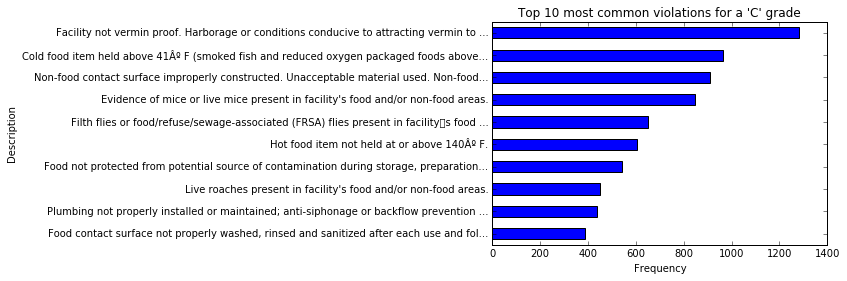

In [44]:
q4[q4['GRADE'] == 'C']['VIOLATION DESCRIPTION CURTAILED'].value_counts()[0:10][::-1].plot(kind='barh')
plt.title("Top 10 most common violations for a 'C' grade")
plt.ylabel("Description")
plt.xlabel("Frequency")

In [45]:
print("Total sum for all reasons for grade C: ", 
      q4[q4['GRADE'] == 'C']['VIOLATION DESCRIPTION CURTAILED'].value_counts().sum())
print("Sum for top 4 reasons: ", 
      q4[q4['GRADE'] == 'C']['VIOLATION DESCRIPTION CURTAILED'].value_counts()[0:4][::-1].sum())
print("Percentage of violations for top 4: ",
      q4[q4['GRADE'] == 'C']['VIOLATION DESCRIPTION CURTAILED'].value_counts()[0:4][::-1].sum()/
      q4[q4['GRADE'] == 'C']['VIOLATION DESCRIPTION CURTAILED'].value_counts().sum() * 100)
print("Percentage of violations for the top reason: ",
      q4[q4['GRADE'] == 'C']['VIOLATION DESCRIPTION CURTAILED'].value_counts()[0:1][::-1].sum()/
      q4[q4['GRADE'] == 'C']['VIOLATION DESCRIPTION CURTAILED'].value_counts().sum() * 100)
q4[q4['GRADE'] == 'C']['VIOLATION DESCRIPTION CURTAILED'].value_counts()[0:4][::-1]

Total sum for all reasons for grade C:  10576
Sum for top 4 reasons:  4001
Percentage of violations for top 4:  37.8309379728
Percentage of violations for the top reason:  12.1123298033


Evidence of mice or live mice present in facility's food and/or non-food areas.              848
Non-food contact surface improperly constructed. Unacceptable material used. Non-food...     910
Cold food item held above 41Âº F (smoked fish and reduced oxygen packaged foods above...     962
Facility not vermin proof. Harborage or conditions conducive to attracting vermin to ...    1281
Name: VIOLATION DESCRIPTION CURTAILED, dtype: int64

#### Grade B

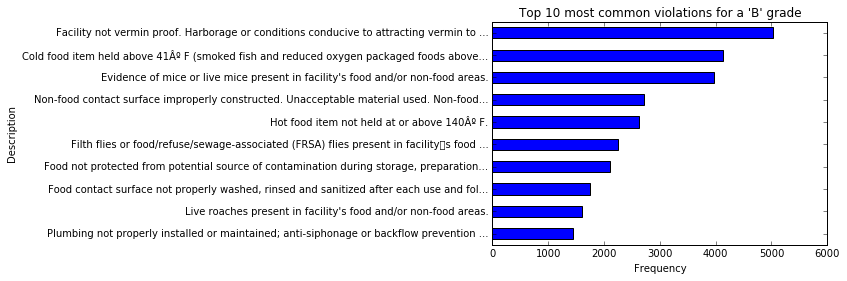

In [46]:
q4[q4['GRADE'] == 'B']['VIOLATION DESCRIPTION CURTAILED'].value_counts()[0:10][::-1].plot(kind='barh')
plt.title("Top 10 most common violations for a 'B' grade")
plt.ylabel("Description")
plt.xlabel("Frequency")

In [47]:
print("Total sum for all reasons for grade B: ", 
      q4[q4['GRADE'] == 'B']['VIOLATION DESCRIPTION CURTAILED'].value_counts().sum())
print("Sum for top 4 reasons: ", 
      q4[q4['GRADE'] == 'B']['VIOLATION DESCRIPTION CURTAILED'].value_counts()[0:4][::-1].sum())
print("Percentage of violations for top 4: ",
      q4[q4['GRADE'] == 'B']['VIOLATION DESCRIPTION CURTAILED'].value_counts()[0:4][::-1].sum()/
      q4[q4['GRADE'] == 'B']['VIOLATION DESCRIPTION CURTAILED'].value_counts().sum() * 100)
print("Percentage of violations for the top reason: ",
      q4[q4['GRADE'] == 'B']['VIOLATION DESCRIPTION CURTAILED'].value_counts()[0:1][::-1].sum()/
      q4[q4['GRADE'] == 'B']['VIOLATION DESCRIPTION CURTAILED'].value_counts().sum() * 100)
q4[q4['GRADE'] == 'B']['VIOLATION DESCRIPTION CURTAILED'].value_counts()[0:4][::-1]

Total sum for all reasons for grade B:  38292
Sum for top 4 reasons:  15840
Percentage of violations for top 4:  41.3663428392
Percentage of violations for the top reason:  13.1202339914


Non-food contact surface improperly constructed. Unacceptable material used. Non-food...    2721
Evidence of mice or live mice present in facility's food and/or non-food areas.             3972
Cold food item held above 41Âº F (smoked fish and reduced oxygen packaged foods above...    4123
Facility not vermin proof. Harborage or conditions conducive to attracting vermin to ...    5024
Name: VIOLATION DESCRIPTION CURTAILED, dtype: int64

#### Grade A

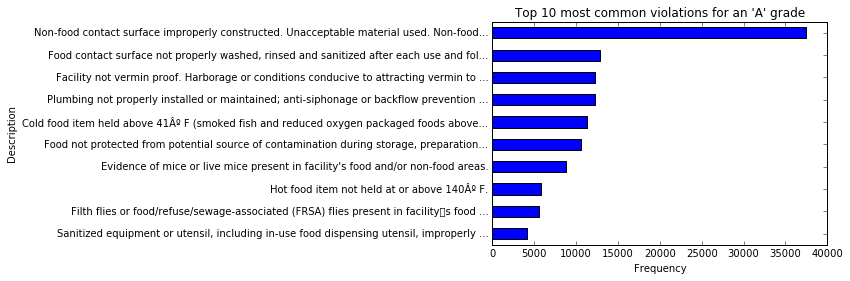

In [48]:
q4[q4['GRADE'] == 'A']['VIOLATION DESCRIPTION CURTAILED'].value_counts()[0:10][::-1].plot(kind='barh')
plt.title("Top 10 most common violations for an 'A' grade")
plt.ylabel("Description")
plt.xlabel("Frequency")

In [49]:
print("Total sum for all violation reasons for grade A: ", 
      q4[q4['GRADE'] == 'A']['VIOLATION DESCRIPTION CURTAILED'].value_counts().sum())
print("Sum for top reason: ", 
      q4[q4['GRADE'] == 'A']['VIOLATION DESCRIPTION CURTAILED'].value_counts()[0:1][::-1].sum())
print("Percentage of violations for top reason: ",
      q4[q4['GRADE'] == 'A']['VIOLATION DESCRIPTION CURTAILED'].value_counts()[0:1][::-1].sum()/
      q4[q4['GRADE'] == 'A']['VIOLATION DESCRIPTION CURTAILED'].value_counts().sum() * 100)
q4[q4['GRADE'] == 'A']['VIOLATION DESCRIPTION CURTAILED'].value_counts()[0:1][::-1]

Total sum for all violation reasons for grade A:  162181
Sum for top reason:  37498
Percentage of violations for top reason:  23.1210807678


Non-food contact surface improperly constructed. Unacceptable material used. Non-food...    37498
Name: VIOLATION DESCRIPTION CURTAILED, dtype: int64

From the three plots, it can be seen that the top violations cited for restaurants that received a 'C' are similar to those cited for restaurant inspections that resulted in a 'B' grade. In particular, the facility not being vermin-proof, improper temperature conditions for cold food, improper materials used for non-food contact surfaces, and evidence and/or presence of mice were the top 4 violation descriptions (out of 96 unique violation descriptions) and accounted for ~40% of all cited violations when a 'B' or 'C' grade was assigned.

### Question \#5: What is the percentage of "A"-graded restaurants with critical flags? What are the most common reasons for this?

In [50]:
q5 = df_dedupeID.copy() # df_dedupeID is used to get the most recent inspections for "A"-graded restaurants
q5.dtypes

CAMIS                      int64
DBA                       object
BORO                      object
BUILDING                  object
STREET                    object
ZIPCODE                    int64
PHONE                     object
CUISINE DESCRIPTION       object
ACTION                    object
VIOLATION CODE            object
VIOLATION DESCRIPTION     object
CRITICAL FLAG             object
SCORE                    float64
GRADE                     object
GRADE DATE                object
RECORD DATE               object
INSPECTION TYPE           object
dtype: object

In [51]:
q5[q5['GRADE'] == 'A']['CRITICAL FLAG'].value_counts()

Critical          16965
Not Critical       3394
Not Applicable      209
Name: CRITICAL FLAG, dtype: int64

In [52]:
# Percentage of "A"-graded inspections with critical flags
crit = 100*(q5[q5['GRADE'] == 'A']['CRITICAL FLAG'] == 'Critical').sum()
/(q5[q5['GRADE'] == 'A']['CRITICAL FLAG'].value_counts().sum())
print("Percentage of inspections resulting in an 'A' grade, but with critical violations:", round(crit, 2))

Percentage of inspections resulting in an 'A' grade, but with critical violations: 82.48


Even for 'A'-graded restaurants, over 82% of them have been issued critical flags from sanitary inspections. From this, we cannot say that high performing restaurants are guaranteed to be safe places to eat... Critical flags, violation codes, and scores should be considered when picking a restaurant!

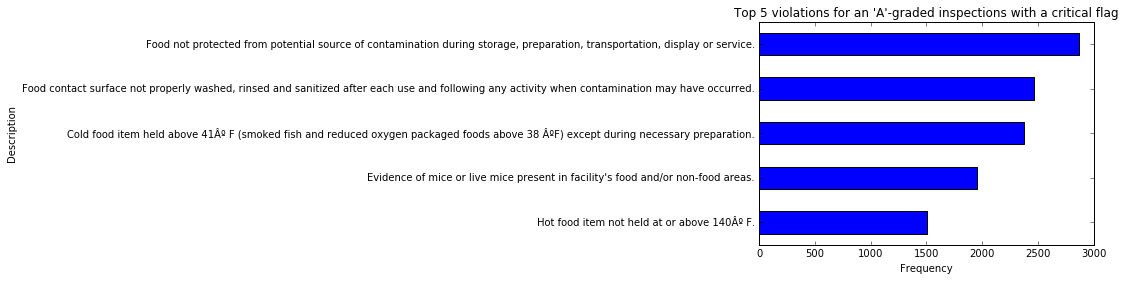

In [53]:
q5_a = q5[q5['GRADE'] == 'A']
q5_a[q5_a['CRITICAL FLAG'] == 'Critical']['VIOLATION DESCRIPTION'].value_counts()[0:5][::-1].plot(kind='barh')
plt.title("Top 5 violations for an 'A'-graded inspections with a critical flag")
plt.xlabel("Frequency")
plt.ylabel("Description")

### Question \#6: Do restaurants with excellent initial results continue to perform well?

In [54]:
df678 = df_dedupe.copy()
restaurant_status = {} # To record improvement, decline, or neither
restaurant_status2 = {}  # To record the "grade" of the first yearly mean (calculated from score) as initial status,
# then "score" of most recent yearly mean as the final status

print("unique restaurants: ", len(df678['CAMIS'].unique()))
for identifier in df678['CAMIS'].unique():
    
    # Create the dataframe for the restaurant
    curr_df = df678[df678['CAMIS'] == identifier]
    curr_df = curr_df[['SCORE','INSPECTION TYPE']]
    curr_df = curr_df[curr_df['SCORE'].isnull() == False] # We're interested in inspections that were scored

    # Compute a dataframe with yearly means for this restaurant
    means = pd.DataFrame()
    for year in ('2010', '2011', '2012', '2013', '2014', '2015', '2016'): # 2010 is the year grading began
        try:
            means[year] = curr_df[year].mean()
        except:
            pass

    # Move on to the next restaurant if there is no data
    means = means.T
    try:
        means.columns = ['Yearly Mean']
        means['Yearly Mean'].astype('float64')
    except:
        continue
    
    earliest_result = ""
    latest_result = ""
    if means.size > 1: # Means for at least 2 years in order to compare
        if means['Yearly Mean'][0] < 0 or means['Yearly Mean'][-1] < 0:
            restaurant_status[int(identifier)] = 'Error'
        else:
            # Compare the mean score of the earliest year with that of the latest year
            if means['Yearly Mean'][0] > means['Yearly Mean'][-1]:
                restaurant_status[int(identifier)] = 'Improvement'
            elif means['Yearly Mean'][0] < means['Yearly Mean'][-1]:
                restaurant_status[int(identifier)] = 'Decline'
            else:
                restaurant_status[int(identifier)] = 'Same'
    
        # Create a more detailed status. An 'Improvment' in 'STATUS' would be the result of the following cases:
        # restaurant 1: mean score of 50 in year 1 & mean score of 45 in year 2
        # restaurant 2: mean score of 38 in year 1 & mean score of 7 in year 2
        # So, it might be helpful to know whether an improvement/decline occurred and caused a grade change or not
        
        if means['Yearly Mean'][0] > 28:  # C
            earliest_result = 'Poor'
        elif means['Yearly Mean'][0] > 14:  # B
            earliest_result = 'Decent'
        elif means['Yearly Mean'][0] > -1:  # A
            earliest_result = 'Excellent'
        else:
            earliest_result = 'Unreliable'
        
        if means['Yearly Mean'][-1] > 28:  # C
            latest_result = 'Poor'
        elif means['Yearly Mean'][-1] > 14:  # B
            latest_result = 'Decent'
        elif means['Yearly Mean'][-1] > -1:  # A
            latest_result = 'Excellent'
        else:
            latest_result = 'Unreliable'
    
        restaurant_status2[int(identifier)] = (earliest_result, latest_result)
    
print(len(restaurant_status))  # Number will be lower than unique restaurants because we need 2 yearly score means to compare
print(len(restaurant_status2)) # Should be the same as above

unique restaurants:  24908
21489
21489


In [55]:
rs_df = pd.DataFrame(list(restaurant_status.items()), columns=['UNIQUE CAMIS', 'STATUS'])
rs_df['STATUS'].value_counts()

Improvement    11740
Decline         8933
Same             815
Error              1
Name: STATUS, dtype: int64

In [56]:
detstatus = pd.DataFrame(list(restaurant_status2.items()), columns=['UNIQUE CAMIS', 'DETAILED STATUS'])
detstatus['INITIAL STATUS'] = detstatus['DETAILED STATUS'].map(lambda x: str(x[0]))
detstatus['FINAL STATUS'] = detstatus['DETAILED STATUS'].map(lambda x: str(x[1]))
detstatus.pop('DETAILED STATUS')
detstatus.head()

,UNIQUE CAMIS,INITIAL STATUS,FINAL STATUS
0,41484288,Decent,Decent
1,41353218,Decent,Excellent
2,41675435,Excellent,Excellent
3,41637206,Decent,Excellent
4,41385990,Excellent,Excellent


In [57]:
detstatus['INITIAL STATUS'].value_counts()

Excellent    13061
Decent        7479
Poor           949
Name: INITIAL STATUS, dtype: int64

Percentage of (initially excellent) restaurants that continue to do excellent:  77.57
Percentage of restaurants with excellent initial results that most recently have decent or excellent results:  98.13


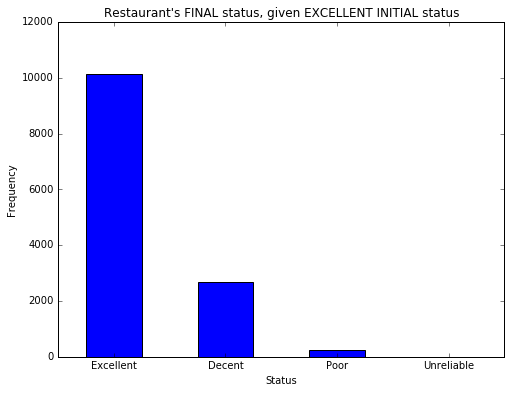

In [58]:
# Restaurants that did well for the first year they were inspected typically do well in their most recent inspections.
# 77% stand strong with excellent final results!
# Only ~2% went from Excellent to Poor!
excellent_excellent = (detstatus[detstatus['INITIAL STATUS'] == 'Excellent']['FINAL STATUS'] == 'Excellent').sum()
excellent_decent = (detstatus[detstatus['INITIAL STATUS'] == 'Excellent']['FINAL STATUS'] == 'Decent').sum()
excellent_total = (detstatus[detstatus['INITIAL STATUS'] == 'Excellent']['FINAL STATUS']).value_counts().sum()
print("Percentage of (initially excellent) restaurants that continue to do excellent: ",\
      round(100 * excellent_excellent / excellent_total, 2))
print("Percentage of restaurants with excellent initial results that most recently have decent or excellent results: ",\
    round(100 * (excellent_excellent + excellent_decent) / excellent_total, 2))

detstatus[detstatus['INITIAL STATUS'] == 'Excellent']['FINAL STATUS'].value_counts().plot('bar', rot=0, figsize=(8,6))
plt.ylabel("Frequency")
plt.xlabel("Status")
plt.title("Restaurant's FINAL status, given EXCELLENT INITIAL status")

### Question \#7: Do restaurants with poor initial results improve over time?

Percentage of restaurants with poor results that continue to doing poorly:  8.01
Percentage of restaurants with poor initial results that most recently have decent or excellent results:  91.99


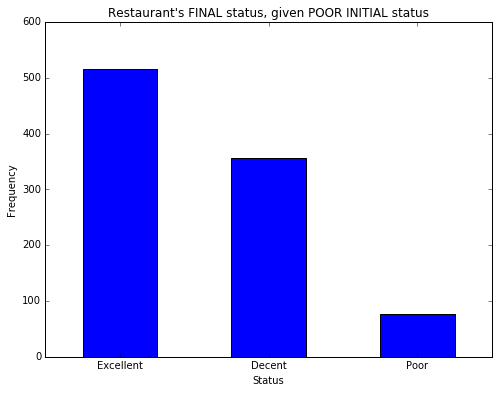

In [59]:
# Over 90% of restaurants with poor initial results improve!
# 8% still have poor results in most recent inspections.
poor_excellent = (detstatus[detstatus['INITIAL STATUS'] == 'Poor']['FINAL STATUS'] == 'Excellent').sum()
poor_decent = (detstatus[detstatus['INITIAL STATUS'] == 'Poor']['FINAL STATUS'] == 'Decent').sum()
poor_total = (detstatus[detstatus['INITIAL STATUS'] == 'Poor']['FINAL STATUS']).value_counts().sum()
print("Percentage of restaurants with poor results that continue to doing poorly: ",\
      round(100 * (1 - (poor_excellent + poor_decent) / poor_total), 2))
print("Percentage of restaurants with poor initial results that most recently have decent or excellent results: ",\
    round(100 * (poor_excellent + poor_decent) / poor_total, 2))

detstatus[detstatus['INITIAL STATUS'] == 'Poor']['FINAL STATUS'].value_counts().plot('bar', rot=0, figsize=(8,6))
plt.ylabel("Frequency")
plt.xlabel("Status")
plt.title("Restaurant's FINAL status, given POOR INITIAL status")

### Question \#8: How do restaurants with neither excellent nor terrible initial results perform?

Percentage of restaurants with decent results that continue to doing the same:  33.11
Percentage of restaurants with decent initial results that most recently have decent or excellent results:  96.03


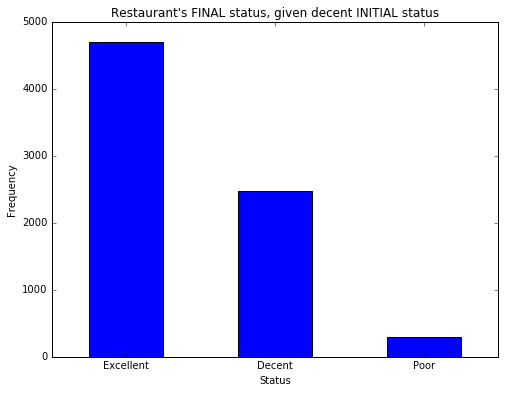

In [60]:
# 96% of restaurants with the equivalent of a 'B' grade either remain at a 'B' (33% of total) or improve (63%)
# This, of course, means that only 4% have poor results in their most recent inspections.
decent_excellent = (detstatus[detstatus['INITIAL STATUS'] == 'Decent']['FINAL STATUS'] == 'Excellent').sum()
decent_decent = (detstatus[detstatus['INITIAL STATUS'] == 'Decent']['FINAL STATUS'] == 'Decent').sum()
decent_total = (detstatus[detstatus['INITIAL STATUS'] == 'Decent']['FINAL STATUS']).value_counts().sum()
print("Percentage of restaurants with decent results that continue to doing the same: ",\
      round(100 * (decent_decent / decent_total), 2))
print("Percentage of restaurants with decent initial results that most recently have decent or excellent results: ",\
    round(100 * (decent_excellent + decent_decent) / decent_total, 2))

detstatus[detstatus['INITIAL STATUS'] == 'Decent']['FINAL STATUS'].value_counts().plot('bar', rot=0, figsize=(8,6))
plt.ylabel("Frequency")
plt.xlabel("Status")
plt.title("Restaurant's FINAL status, given decent INITIAL status")

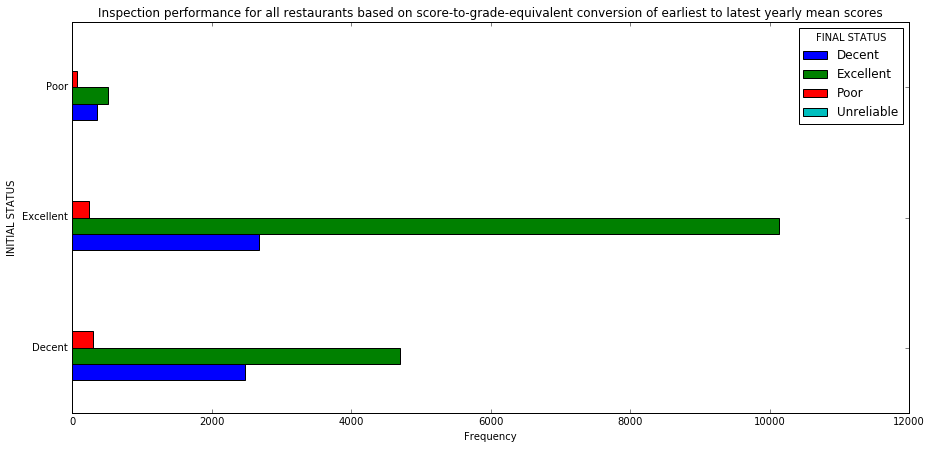

In [61]:
# Combined plot
detstatus_grouped = detstatus.groupby(['INITIAL STATUS', 'FINAL STATUS'])
grouped = detstatus_grouped['FINAL STATUS'].count()
grouped.unstack().plot(kind='barh', figsize=(15,7))
plt.title('Inspection performance for all restaurants based on score-to-grade-equivalent conversion of earliest to latest yearly mean scores')
plt.xlabel('Frequency')

### Question \#9: What is the number of restaurants per grade (all NYC and per borough?)

#### 9a) in all NYC

In [62]:
# df_dedupe_ID will be used for the count of restaurants so that each restaurant is only counted once
print("Number of restaurants in the dataset:", len(df_dedupeID))
print("Number of restaurants with a grade:", df_dedupeID.GRADE.count())
print("Number of restaurants with no grade:", len(df_dedupeID) - df_dedupeID.GRADE.count())
print("")
print("Number of restaurants per grade in NYC:")
df_dedupeID.GRADE.fillna("Missing grade").value_counts().sort_index()

Number of restaurants in the dataset: 24908
Number of restaurants with a grade: 22991
Number of restaurants with no grade: 1917

Number of restaurants per grade in NYC:


A                 20568
B                  1275
C                   101
Missing grade      1917
Not Yet Graded      540
Z                   507
Name: GRADE, dtype: int64

#### 9b) per borough in NYC

In [63]:
df_dedupeID2 = df_dedupeID.copy()
df_dedupeID2.GRADE.fillna("Missing grade", inplace=True)
grouped_boro = df_dedupeID2.groupby('BORO')
print("Number of restaurants per grade per NYC boroughs")
grouped_boro.GRADE.value_counts().sort_index()

Number of restaurants per grade per NYC boroughs


BORO           GRADE         
BRONX          A                 1882
               B                  152
               C                   10
               Missing grade      175
               Not Yet Graded      49
               Z                   59
BROOKLYN       A                 4913
               B                  244
               C                   27
               Missing grade      541
               Not Yet Graded     173
               Z                  129
MANHATTAN      A                 8390
               B                  507
               C                   35
               Missing grade      722
               Not Yet Graded     190
               Z                  181
Missing        A                    5
QUEENS         A                 4620
               B                  316
               C                   23
               Missing grade      406
               Not Yet Graded     101
               Z                  126
STATEN ISLAND  A    

In [64]:
# trying a different approach to group with 2 columns BORO and GRADE to plot the same results
# Note: for plotting, removed the missing boroughs (only 5 restaurants)
grouped_boro2 = df_dedupeID2[df_dedupeID2.BORO != "Missing"].groupby(['BORO', 'GRADE'])  
grouped = grouped_boro2.GRADE.count().sort_index()

# Challenge was to find a way to plot on a bar chart with the BORO as main group and GRADE as subgroup
grouped.unstack().head()  # solution: unstack

GRADE,A,B,C,Missing grade,Not Yet Graded,Z
BORO,,,,,,
BRONX,1882,152,10,175,49,59
BROOKLYN,4913,244,27,541,173,129
MANHATTAN,8390,507,35,722,190,181
QUEENS,4620,316,23,406,101,126
STATEN ISLAND,758,56,6,73,27,12


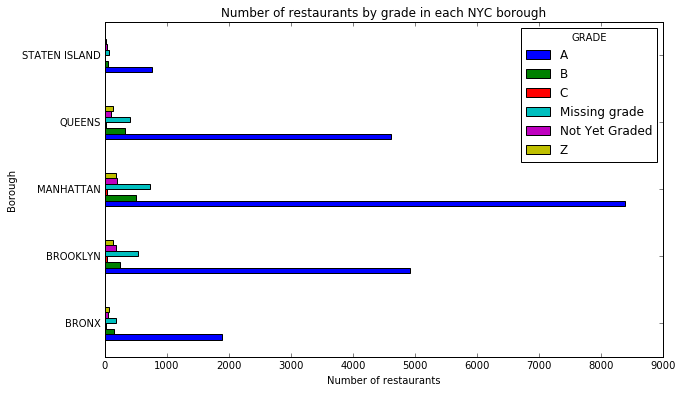

In [65]:
grouped.unstack().plot(kind='barh', figsize=(10,6))
plt.title("Number of restaurants by grade in each NYC borough")
plt.xlabel("Number of restaurants")
plt.ylabel("Borough")

We also noted that the count alone is not sufficient to get a good idea of the "good" vs "bad" boroughs. It would be interesting to see the percentage of bad graded restaurants in each borough.

In the table below, in fact all boroughs are very similar but it is always good to know that Manhattan is still the most "sanitary" borough!

In [66]:
print("Percentage of restaurants per grade per NYC boroughs: \n")
for name, boro in grouped_boro:
    print(name)
    total = boro.GRADE.count()
    print(boro.GRADE.value_counts().map(lambda x: round(x/total * 100, 2)))
    print("")

Percentage of restaurants per grade per NYC boroughs: 

BRONX
A                 80.88
Missing grade      7.52
B                  6.53
Z                  2.54
Not Yet Graded     2.11
C                  0.43
Name: GRADE, dtype: float64

BROOKLYN
A                 81.52
Missing grade      8.98
B                  4.05
Not Yet Graded     2.87
Z                  2.14
C                  0.45
Name: GRADE, dtype: float64

MANHATTAN
A                 83.69
Missing grade      7.20
B                  5.06
Not Yet Graded     1.90
Z                  1.81
C                  0.35
Name: GRADE, dtype: float64

Missing
A    100.0
Name: GRADE, dtype: float64

QUEENS
A                 82.62
Missing grade      7.26
B                  5.65
Z                  2.25
Not Yet Graded     1.81
C                  0.41
Name: GRADE, dtype: float64

STATEN ISLAND
A                 81.33
Missing grade      7.83
B                  6.01
Not Yet Graded     2.90
Z                  1.29
C                  0.64
Name: GRADE, d

### Question \#10: What is the average score per zipcode? Per borough?

First, let's define the relation between score and grades

- Grade A: score between 0 and 13 points
- Grade B: score between 14 to 27 points
- Grade C: score 28 or more

We will use the df_dedupeID dataframe.

We will first calculate the average score per zipcode and per borough then map the average to a grade.

But first, let's see how the scores are spread.

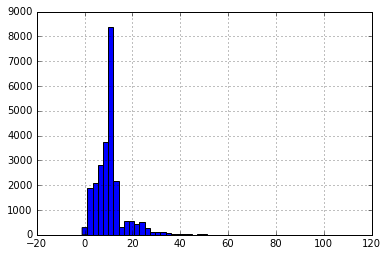

In [67]:
df_dedupeID.SCORE.hist(bins=50)

In [68]:
df_dedupeID.SCORE.describe()

count    24658.000000
mean        10.783113
std          6.852859
min         -1.000000
25%          7.000000
50%         10.000000
75%         12.000000
max        108.000000
Name: SCORE, dtype: float64

Problem: unexpected values

There are some restaurants with negative scores! Let's investigate (e.g.see what their grade is, etc...)

In [69]:
min_score = df_dedupeID.SCORE.min()
print("There are", len(df_dedupeID[df_dedupeID.SCORE == min_score]), "restaurants with a negative score!")
df_dedupeID[df_dedupeID.SCORE == min_score]

There are 7 restaurants with a negative score!


,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE
INSPECTION DATE,,,,,,,,,,,,,,,,,
2015-12-30,41225222,DISHES,MANHATTAN,399,PARK AVENUE,10022,2124215511,American,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140Âº F.,Critical,-1.0,B,12/30/2015,04/07/2016,Cycle Inspection / Re-inspection
2015-12-08,41374876,CEMI CAFE,BROOKLYN,61,CHURCH AVENUE,11218,3477506960,Russian,Violations were cited in the following area(s).,04A,Food Protection Certificate not held by superv...,Critical,-1.0,C,12/08/2015,04/07/2016,Cycle Inspection / Re-inspection
2015-12-10,41519256,BENJYS KOSHER PIZZA & DAIRY RESTAURANT,QUEENS,7272,MAIN STREET,11367,7182680791,Jewish/Kosher,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140Âº F.,Critical,-1.0,B,12/10/2015,04/07/2016,Cycle Inspection / Re-inspection
2015-11-20,50003104,BEDFORD PIZZA CAFE,BRONX,380,BEDFORD PARK BLVD,10458,9178010770,Pizza/Italian,Violations were cited in the following area(s).,02G,Cold food item held above 41Âº F (smoked fish ...,Critical,-1.0,B,11/20/2015,04/07/2016,Cycle Inspection / Re-inspection
2015-12-07,50007470,LE BAOBAB-GOUYGUI RESTAURANT,MANHATTAN,120,W 116TH ST,10026,7182947882,African,Violations were cited in the following area(s).,04L,Evidence of mice or live mice present in facil...,Critical,-1.0,B,12/07/2015,04/07/2016,Cycle Inspection / Re-inspection
2016-02-01,50033364,EL ORIGINAL,MANHATTAN,735,10TH AVE,10019,9173825512,Tex-Mex,Violations were cited in the following area(s).,04A,Food Protection Certificate not held by superv...,Critical,-1.0,B,02/01/2016,04/07/2016,Cycle Inspection / Re-inspection
2016-01-19,50034730,TURNTABLE 5060,MANHATTAN,235,E 4TH ST,10009,2127775060,American,Violations were cited in the following area(s).,04B,Food worker prepares food or handles utensil w...,Critical,-1.0,B,01/19/2016,04/07/2016,Pre-permit (Operational) / Re-inspection


In [70]:
# Peek at a test case using the dataframe df_dated with contains all inspection dates
df_dated[df_dated.CAMIS == 50034730]

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE
INSPECTION DATE,,,,,,,,,,,,,,,,,
2016-01-19,50034730,TURNTABLE 5060,MANHATTAN,235,E 4TH ST,10009,2127775060,American,Violations were cited in the following area(s).,04B,Food worker prepares food or handles utensil w...,Critical,-1.0,B,01/19/2016,04/07/2016,Pre-permit (Operational) / Re-inspection
2016-01-19,50034730,TURNTABLE 5060,MANHATTAN,235,E 4TH ST,10009,2127775060,American,Violations were cited in the following area(s).,06D,"Food contact surface not properly washed, rins...",Critical,-1.0,B,01/19/2016,04/07/2016,Pre-permit (Operational) / Re-inspection
2016-01-19,50034730,TURNTABLE 5060,MANHATTAN,235,E 4TH ST,10009,2127775060,American,Violations were cited in the following area(s).,10H,Proper sanitization not provided for utensil w...,Not Critical,-1.0,B,01/19/2016,04/07/2016,Pre-permit (Operational) / Re-inspection
2016-01-19,50034730,TURNTABLE 5060,MANHATTAN,235,E 4TH ST,10009,2127775060,American,Violations were cited in the following area(s).,15L,Smoke free workplace smoking policy inadequate...,Not Critical,NaN,NaN,NaN,04/07/2016,Smoke-Free Air Act / Re-inspection
2015-10-21,50034730,TURNTABLE 5060,MANHATTAN,235,E 4TH ST,10009,2127775060,American,Violations were cited in the following area(s).,05D,Hand washing facility not provided in or near ...,Critical,14.0,NaN,NaN,04/07/2016,Pre-permit (Operational) / Initial Inspection
2015-10-21,50034730,TURNTABLE 5060,MANHATTAN,235,E 4TH ST,10009,2127775060,American,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,Not Critical,14.0,NaN,NaN,04/07/2016,Pre-permit (Operational) / Initial Inspection
2015-10-21,50034730,TURNTABLE 5060,MANHATTAN,235,E 4TH ST,10009,2127775060,American,Violations were cited in the following area(s).,10J,''''Wash hands sign not posted at hand wash f...,Not Critical,14.0,NaN,NaN,04/07/2016,Pre-permit (Operational) / Initial Inspection


In [71]:
neg_score = df_dedupeID[df_dedupeID.SCORE == min_score][['CAMIS','GRADE']]
neg_score

,CAMIS,GRADE
INSPECTION DATE,,
2015-12-30,41225222,B
2015-12-08,41374876,C
2015-12-10,41519256,B
2015-11-20,50003104,B
2015-12-07,50007470,B
2016-02-01,50033364,B
2016-01-19,50034730,B


Looking at other test cases, the negative scores have grades below A and should be considered in our calculations. But how?

We will copy the score available at a previous inspection date using the dataframe df_dedupe

In [72]:
df_scores = df_dedupeID.copy()
df_scores['SCORE2'] = df_dedupeID.SCORE


for identifier in neg_score.CAMIS:
    test = df_dedupe[df_dedupe.CAMIS == identifier]
    test2 = test[test.SCORE >= 0].SCORE[0]
    print(test2)
    df_scores.loc[df_scores.CAMIS == identifier,'SCORE2'] = test2
    
    
df_scores[df_scores.SCORE == min_score][['CAMIS', 'GRADE', 'SCORE', 'SCORE2']]

10.0
18.0
29.0
33.0
17.0
31.0
14.0


,CAMIS,GRADE,SCORE,SCORE2
INSPECTION DATE,,,,
2015-12-30,41225222,B,-1.0,10.0
2015-12-08,41374876,C,-1.0,18.0
2015-12-10,41519256,B,-1.0,29.0
2015-11-20,50003104,B,-1.0,33.0
2015-12-07,50007470,B,-1.0,17.0
2016-02-01,50033364,B,-1.0,31.0
2016-01-19,50034730,B,-1.0,14.0


Problem # 2: Except for 2 cases, the old scores do not match with the most recent grade based on:
- Grade A: score between 0 and 13 points
- Grade B: score between 14 to 27 points
- Grade C: score 28 or more


In [73]:
def adjust_score(grade, score):
    score_a_min = 0
    score_a_max = 13
    score_b_min = 14
    score_b_max = 27
    score_c_min = 28
    
    if grade == 'B':
        if score < score_b_min:
            score = score_b_min
        elif score > score_b_max:
            score = score_b_max
    elif grade == 'C':
        if score < score_c_min:
            score = score_c_min
    
    return score
            

dff = df_scores[df_scores.SCORE == min_score].apply(lambda x: adjust_score(x['GRADE'], x['SCORE2']), axis=1)
df_scores.loc[df_scores.SCORE == min_score,'SCORE2'] = dff


In [74]:
df_scores[df_scores.SCORE == min_score][['CAMIS', 'GRADE', 'SCORE', 'SCORE2']]

,CAMIS,GRADE,SCORE,SCORE2
INSPECTION DATE,,,,
2015-12-30,41225222,B,-1.0,14.0
2015-12-08,41374876,C,-1.0,28.0
2015-12-10,41519256,B,-1.0,27.0
2015-11-20,50003104,B,-1.0,27.0
2015-12-07,50007470,B,-1.0,17.0
2016-02-01,50033364,B,-1.0,27.0
2016-01-19,50034730,B,-1.0,14.0


In [75]:
df_scores.SCORE2.describe()
# no more negative scores

count    24658.000000
mean        10.789642
std          6.853367
min          0.000000
25%          7.000000
50%         10.000000
75%         12.000000
max        108.000000
Name: SCORE2, dtype: float64

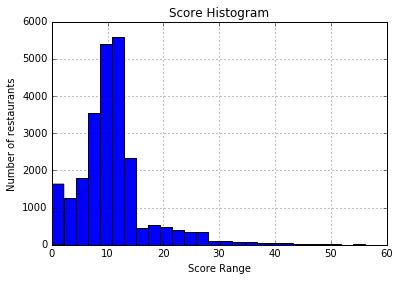

In [76]:
# To have a quick view of how the scores are distributed within the city
df_scores.SCORE2.hist(bins=50)
plt.xlim((0,60))
plt.xlabel("Score Range")
plt.ylabel("Number of restaurants")
plt.title("Score Histogram")

In [77]:
df_scores.groupby(['BORO']).SCORE2.mean().round(2)

BORO
BRONX            10.72
BROOKLYN         11.04
MANHATTAN        10.57
Missing           7.60
QUEENS           10.90
STATEN ISLAND    11.09
Name: SCORE2, dtype: float64

In [78]:
df_scores.groupby(['BORO']).SCORE2.std().round(2)

BORO
BRONX            6.71
BROOKLYN         7.28
MANHATTAN        6.77
Missing          2.79
QUEENS           6.53
STATEN ISLAND    7.10
Name: SCORE2, dtype: float64

Observations:
1. Afterall, Manhattan looks the "safest" borough!
2. All boroughs have an average score under 14 which means an average grade of A
3. However, the standard deviation of around 7 means that there is still a good fluctation from grade A... To be careful!
4. Also a reminder that grade A does not mean sanitary based on our observations! There are some critical flags which are quite unpleasant to know...

### Question \#11: How are the scores distributed per borough?

Challenge: decide whether table from describe() or graph from boxplot would be more fitted for this question. We decided to use a boxplot to visualize how the boroughs are similar: same box size more or less aligned. It also highlights well an outlier of 108 points in Bronx!

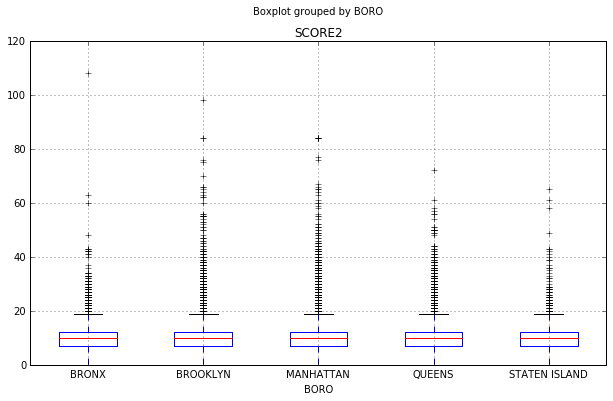

In [79]:
df_scores[df_scores.BORO != 'Missing'].boxplot(column='SCORE2', by='BORO', figsize=(10,6))

From the boxplot, we can see that the scores distribution is quite similar for each boroughs and there are no much difference.

### Question \#12: Visualization of average scores on an actual map of NYC by zip code areas

We will continue to use the df_scores dataframe derived from the df_dedupeID (one restaurant data with one inspection date).

Note that we will plot the average scores instead of average grades since scores have numerical values.

The df_scores is the dataframe we have adjusted for the negative scores.

In [80]:
print("Number of distinct zipcodes:", df_scores.ZIPCODE.value_counts().size)

Number of distinct zipcodes: 230


In [81]:
average_scores = df_scores.groupby('ZIPCODE').SCORE2.agg(np.mean)
average_scores.head()

ZIPCODE
7005      2.000000
10001    10.066210
10002    10.753915
10003    11.225373
10004     9.918519
Name: SCORE2, dtype: float64

In [82]:
len(average_scores) # to check if equal to number of distinct zipcodes

230

Our biggest challenge: how to plot the average scores on a NYC map!

After some intense research and comparisons of different approaches, we decided to use the geopandas library to read the geospatial data and plot each polygon. We liked the geopandas since it is essentially built on pandas and we can still apply all the concepts we learned from pandas and create our own code for mapping without bluntly copy-pasting codes from googling!

For peer reviewers, you will need to install geopandas before checking the codes below.

In [83]:
# some imports for plotting geospatial data
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from geopandas import GeoSeries, GeoDataFrame
import fiona

In [84]:
# GeoDataFrame works like a DataFrame
nyc_gis = GeoDataFrame.from_file('zipcode.shp')  # to read .shp file that contains geospatial data as "polygon" type
nyc_gis.columns

Index(['AREA', 'BLDGZIP', 'COUNTY', 'CTY_FIPS', 'POPULATION', 'PO_NAME',
       'SHAPE_AREA', 'SHAPE_LEN', 'STATE', 'ST_FIPS', 'URL', 'ZIPCODE',
       'geometry'],
      dtype='object')

In [85]:
nyc_gis.head()  # two columns to be used: ZIPCODE and geometry. Note how the output is like a pandas dataframe!

,AREA,BLDGZIP,COUNTY,CTY_FIPS,POPULATION,PO_NAME,SHAPE_AREA,SHAPE_LEN,STATE,ST_FIPS,URL,ZIPCODE,geometry
0,2.269930e+07,0,Queens,081,18681.0,Jamaica,0.0,0.0,NY,36,http://www.usps.com/,11436,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,2.963100e+07,0,Kings,047,62426.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11213,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,4.197210e+07,0,Kings,047,83866.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11212,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,2.369863e+07,0,Kings,047,56527.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11225,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,3.686880e+07,0,Kings,047,72280.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11218,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [86]:
map_zipcodes = nyc_gis.ZIPCODE.values
map_zipcodes

array(['11436', '11213', '11212', '11225', '11218', '11226', '11219',
       '11210', '11230', '11204', '10471', '10470', '10466', '10467',
       '10463', '10475', '10464', '10469', '10468', '10463', '10458',
       '10034', '10033', '10462', '10040', '10453', '10465', '10464',
       '10464', '10461', '10457', '10460', '10032', '10452', '10456',
       '10472', '10031', '10039', '10459', '10451', '10473', '10030',
       '10027', '10474', '10455', '10037', '10024', '10454', '10026',
       '10035', '10048', '10025', '11357', '10029', '00083', '11356',
       '11359', '11360', '11105', '10128', '10023', '11363', '10028',
       '11354', '11102', '11370', '10021', '11358', '11362', '10044',
       '11369', '11103', '11106', '11368', '11377', '11355', '11101',
       '11364', '10018', '10020', '11005', '10017', '10001', '10011',
       '10016', '11104', '11109', '10010', '11367', '10014', '10003',
       '11222', '10002', '11378', '10009', '10012', '10013', '10007',
       '11237', '113

In [87]:
# from our dataset, remove any zipcode not in this nyc zip code boundaries file
remove_zip = []
for i in range(len(average_scores)):
    if str(average_scores.index[i]) not in map_zipcodes:
        print(average_scores.index[i])
        remove_zip.append(average_scores.index[i])

print(remove_zip)   

7005
10015
10057
10179
10199
10311
10317
10605
11242
11256
11352
[7005, 10015, 10057, 10179, 10199, 10311, 10317, 10605, 11242, 11256, 11352]


In [88]:
for zipcode in remove_zip:
    average_scores.drop(zipcode, axis=0, inplace=True)

In [89]:
print(len(remove_zip))
print(len(average_scores))

11
219


This works since we had 230 zipcodes, removed 11 not in the NYC zip code boundaries file and have 219 left.

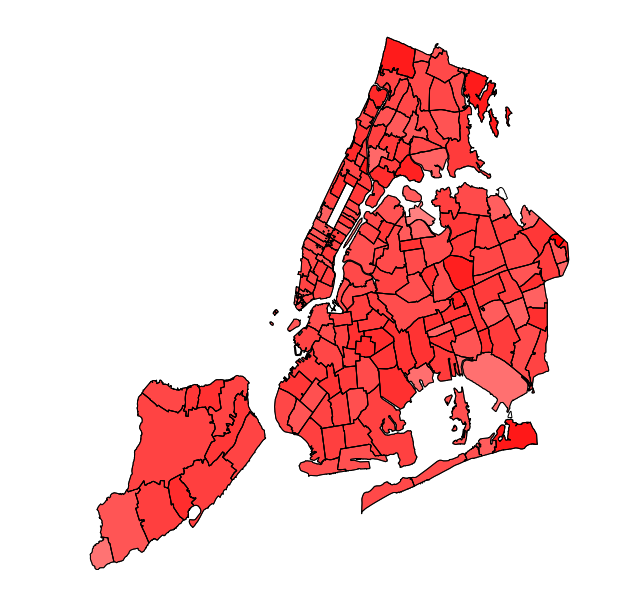

In [90]:
# Now time to plot the scores with different shade of a color on the NYC map!

f, ax = plt.subplots(1, figsize=(10, 10))

zipcolor = 'red'
# See histogram below - most values under 15
max_score = 15 

location = 0
for poly in nyc_gis['geometry']:
    zipcode = nyc_gis.ZIPCODE.values[location]
    if average_scores[average_scores.index == int(zipcode)].any():
        shade = min(1, (average_scores[average_scores.index == int(zipcode)].values[0])/max_score)
    else:
        shade = 0
    gpd.plotting.plot_multipolygon(ax, poly, alpha=shade, facecolor=zipcolor)
    location += 1
ax.set_axis_off()
plt.show()

Problem: Given most average grades are around the same, the colors in the map are not very distinguishable and not helpful

Solution: we will need to distinguish better between different grades and reflect in the scores to highlight the areas with bad grades

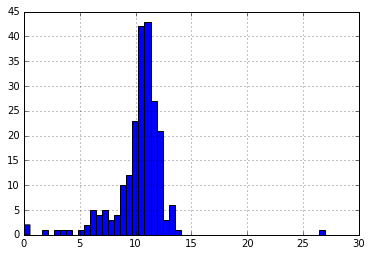

In [91]:
average_scores.hist(bins=50)

In [92]:
def modify_scores(score):
    if score < 14:
        return score
    elif score < 28:
        return score * 1.5  # to bump up the grade B scores for higher weight on bad grade
    else:
        return score * 2  # to bump up the grade C scores for higher weight on bad grade

df_scores['SCORE3'] = df_scores.SCORE2.map(modify_scores)
df_scores[['SCORE2','SCORE3']].head()

,SCORE2,SCORE3
INSPECTION DATE,,
2016-02-18,10.0,10.0
2015-05-07,12.0,12.0
2015-09-21,8.0,8.0
2015-06-05,4.0,4.0
2015-05-29,12.0,12.0


In [93]:
average_scores2 = df_scores.groupby('ZIPCODE').SCORE3.agg(np.mean)
average_scores2.head()

ZIPCODE
7005      2.000000
10001    11.531963
10002    12.850112
10003    13.876119
10004    11.714815
Name: SCORE3, dtype: float64

In [94]:
# loading of 25% to better split average scores between different grades
def modify_avg_score(avg_score):
    if avg_score < 14:
        return avg_score
    elif avg_score < 28:
        return avg_score * 1.25
    else:
        return avg_score * 1.50
    
average_scores2 = average_scores2.map(modify_avg_score)

In [95]:
average_scores2.max()

73.5

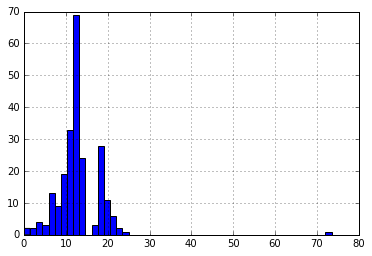

In [96]:
average_scores2.hist(bins=50)

From the histogram, we can see that most average grades are below 25.

In [97]:
for zipcode in remove_zip:
    average_scores2.drop(zipcode, axis=0, inplace=True)

In [98]:
len(average_scores2)

219

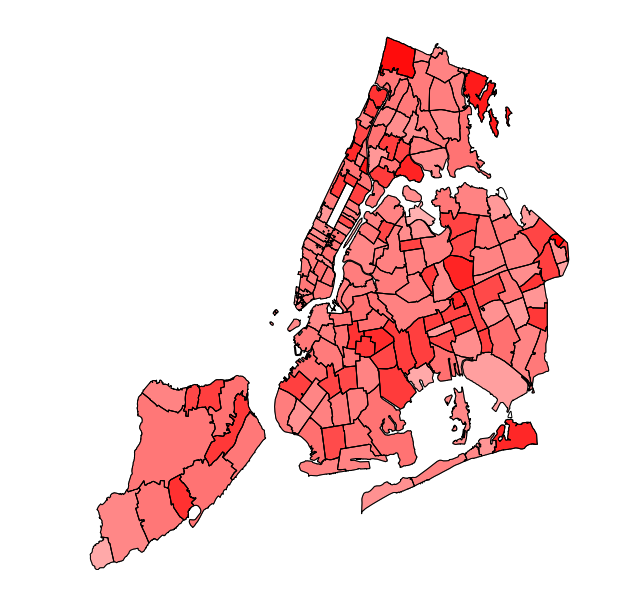

In [99]:
# Now time to plot the scores with different shade of a color on the NYC map!

f, ax = plt.subplots(1, figsize=(10, 10))

zipcolor = 'red'
# See comment above
max_score = 25 

location = 0
for poly in nyc_gis['geometry']:
    zipcode = nyc_gis.ZIPCODE.values[location]
    if average_scores2[average_scores2.index == int(zipcode)].any():
        shade = min(1, (average_scores2[average_scores2.index == int(zipcode)].values[0])/max_score)
    else:
        shade = 0
    gpd.plotting.plot_multipolygon(ax, poly, alpha=shade, facecolor=zipcolor)
    location += 1
ax.set_axis_off()
plt.show()

Problem: This is only one color and still does not highlight the difference between grade A and B/C areas. Maybe try 2 color schemes? See below.

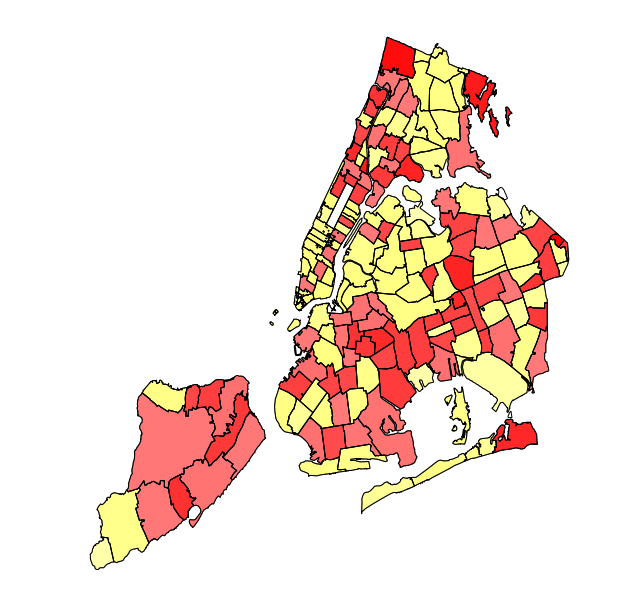

In [100]:
# Now time to plot the scores with different shade of a color on the NYC map!

f, ax = plt.subplots(1, figsize=(10, 10))

#zipcolor = 'red'
# See comment above
max_score = 25 

location = 0
for poly in nyc_gis['geometry']:
    zipcode = nyc_gis.ZIPCODE.values[location]
    if average_scores2[average_scores2.index == int(zipcode)].any():
        avg_score = average_scores2[average_scores2.index == int(zipcode)].values[0]
        if avg_score <= 13.0:
            zipcolor = 'yellow'
            shade = (avg_score/13.0)*0.5  # note: multiplied by 0.5 to avoid a too intense yellow for Grade A
        else:
            zipcolor = 'red'
            shade = min(1.0, avg_score/max_score)
    else:
        shade = 0
        zipcolor = 'white'
    gpd.plotting.plot_multipolygon(ax, poly, alpha=shade, facecolor=zipcolor)
    location += 1
ax.set_axis_off()
plt.show()
# plt.title('NYC Map of Average Grades per Zip Code Areas') --> does not work! need to find a way...

In the final report, we will add a legend with color and shade associated with the grade, i.e., yellow = Grade A and red = Grade B and C. Darker the color, it tends to higher (worse) end of the grade.

Observations from the map:
- The blank rectangular space in Manhattan is correct: it is Central park and thus, no restaurants!
- In Manhattan, in the Midtown and downtown areas, the west side is more sanitary than the east side as expected. The red shaded sections are indeed near the east village and chinatown! Warning!
- In Manhattan, the north area (Harlem and above) is mostly red shaded area. No surprise there neither!
- Brooklyn area near Manhattan seems quite sanitary except for "deeper" Brooklyn. 
- Staten Island is mostly red but more towards the grade B than C.
- Bronx south side is worse but improves in the north area. We have to keep in mind that there may also be less data more we move north of Bronx. 